In [1]:
import numpy as np
import numpy.ma as ma

import jax
import jax.numpy as jnp
from jax import random

import matplotlib as mpl
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, BoundaryNorm

import plotly.graph_objs as go
import plotly.express as px 

from kernels import *
from utils import *



In [10]:

def DDM(mu, sigma, dt, total_time, key, trials):
    num_trajectories = len(mu)
    num_steps = int(total_time / dt)
    x = jnp.zeros((num_trajectories, num_steps + 1))
    ls_RT = []
    ls_acc = []

    keys = random.split(key, num_trajectories)

    for i in range(num_trajectories):
        current_key = keys[i]
        for t in range(num_steps): 
            if jnp.abs(x[i, t]) < 1:
                normal_sample = random.normal(current_key, shape=())
                x = x.at[i, t + 1].set(x[i, t] + mu[i] * dt + sigma * jnp.sqrt(dt) * normal_sample)
                current_key, subkey = random.split(current_key)
            else:
                ls_RT.append(t)
                ls_acc.append(1 if jnp.sign(x[i, t]) == jnp.sign(mu[i]) else -1)
                
                x = x.at[i, t:].set(jnp.sign(x[i, t]))
                break
    return x, ls_RT, ls_acc

mu = np.array([ -0.64, -0.32, -0.16, -0.08, -0.04, 0.0, 0.04, 0.08, 0.16, 0.32, 0.64])  
sigma = 0.35
dt = 0.1
total_time = 100
trials = 10

ls_RTs = []
ls_accs = []
paths = jnp.zeros((trials, len(mu), int(total_time / dt) + 1))
for i in range(trials):
    key = random.PRNGKey(42 + i)
    path, ls_RT, ls_acc = DDM(mu, sigma, dt, total_time, key, trials) 
    paths = paths.at[i].set(path)
    ls_RTs.append(ls_RT)
    ls_accs.append(ls_acc)

accs = jnp.array(ls_accs)
RTs = jnp.array(ls_RTs)
paths = paths[:,:, :jnp.max(RTs)]

#paths_motion_on = paths[:,:, :jnp.min(RTs)]

# single_trial = False
# if single_trial:
#     paths_run = paths.reshape(-1, jnp.max(RTs))
# else:
#     paths_run = jnp.mean(paths, axis=0)#[jnp.newaxis,:,:]

In [29]:
np.save('/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/DDM/paths_50trials', paths)
np.save('/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/DDM/RTs_50trials', RTs)
#paths = np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/DDM/paths_75_trials.npy')

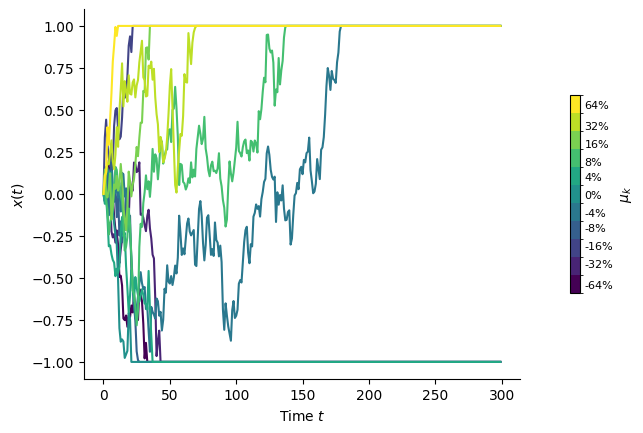

In [3]:

fig, ax = plt.subplots()
#times = np.linspace(0, total_time, int(total_time / dt) + 1)

boundaries = np.concatenate(([mu[0] - (mu[1] - mu[0])/2], (mu[:-1] + mu[1:])/2, [mu[-1] + (mu[-1] - mu[-2])/2]))
norm = mcolors.BoundaryNorm(boundaries, ncolors=len(mu))
cmap = plt.get_cmap('viridis', len(mu))

for i, m in enumerate(mu):
    ax.plot(paths[-1, i, :300], color=cmap(norm(m)))

# ax.axhline(y=1, color='black', linestyle='--')
# ax.axhline(y=-1, color='black', linestyle='--')
ax.set_xlabel('Time $t$')
ax.set_ylabel(r'$x(t)$')


sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
 
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.02, pad=0.1, ticks=mu)
cbar.ax.tick_params(size=0) 
cbar.set_label('$\mu_k$')
cbar.set_ticklabels([f'{100*m:.0f}%' for m in mu], fontsize=8)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [10]:
def parametric_curve_v(x, mu):
    val = len(mu)//2
    x_1 = x[:,:val][:, ::-1]
    x_2 = x[:,val+1:]
    return x_1, x_2

RTs_1, RTs_2 = parametric_curve_v(RTs, mu)
accs_1, accs_2 = parametric_curve_v(accs, mu)

val = len(mu)//2
RTs_p = (RTs_1 + RTs_2) /2 
RTs_p = jnp.concatenate((RTs[:,val][:,jnp.newaxis], RTs_p), axis=1)

p_correct_1 = (jnp.sum(accs_1 == 1, axis=0) / accs_1.shape[0]) * 100
p_correct_2 = (jnp.sum(accs_2 == 1, axis=0) / accs_2.shape[0]) * 100
p_correct = (p_correct_1 + p_correct_2) /2 
p_correct = jnp.concatenate((jnp.array([50]), p_correct), axis=0)

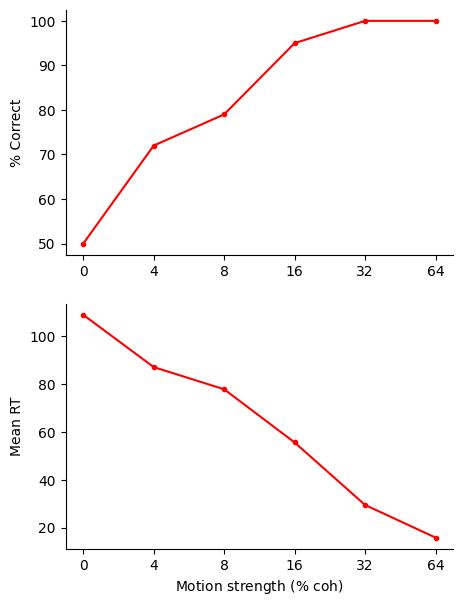

In [11]:
fig, axs = plt.subplots(2, 1, figsize=(5,7))

axs[0].plot(p_correct, marker='.', color='r' )
axs[0].set_ylabel('% Correct')
axs[1].plot(jnp.mean(RTs_p, axis=0), marker='.', color='r')
axs[1].set_ylabel('Mean RT')
axs[1].set_xlabel('Motion strength ($\%$ coh)')
for ax in axs:
    ax.spines[['right', 'top']].set_visible(False)
    ticks = np.arange(len(mu[val:]))  
    tick_labels = [f"{int(x * 100)}" for x in mu[val:]]  
    ax.set_xticks(ticks)  
    ax.set_xticklabels(tick_labels)  



In [37]:
def project(paths, key, proj_dims = 50):
    proj_matrix = random.normal(key, (proj_dims, 1))
    proj_matrix , _ = jnp.linalg.qr(proj_matrix)                                        #(N',N)
    return jnp.einsum('dn,lknt->lkdt', proj_matrix, paths[:,:,jnp.newaxis,:])           #(K, N=1, T) #trial, 

def relu(x):
    return jnp.maximum(0, x)

def add_low_rank_noise(X, key1, key2, proj_dims = 3, sigma = 2, l2_=0.01 ):
    trial, K, N, T = X.shape    
    B = random.normal(key1, (N, proj_dims))
    B, _ = jnp.linalg.qr(B)

    time_points = jnp.linspace(0, 1, T)[None, :]
    cov_matrix = K_X_Y_squared_exponential(time_points, time_points, l2=l2_)
    L = jnp.linalg.cholesky(cov_matrix + jnp.identity(T) * 1e-5)

    epsilon_t_uncorr = random.normal(key2, (trial, K, T, proj_dims)) * sigma  
    epsilon_t = jnp.einsum("ts,lksd->lktd", L, epsilon_t_uncorr)
    noise = jnp.einsum('lktd,nd->lknt', epsilon_t, B)             
    
    X += noise                                                   
    return X, noise, cov_matrix


key = random.PRNGKey(0)
key1, key2, key3 = random.split(key, 3)

T = paths.shape[-1]
T = (T // 10) * 10 
reshaped_paths = paths[:,:,:T].reshape(paths.shape[0], paths.shape[1], -1, 5)
reshaped_paths = reshaped_paths.mean(axis=-1)


neural_traces = project(paths , key1) #relu 
#neural_traces = jnp.mean( neural_traces, axis=0 )

neural_traces = neural_traces * 5

neural_traces, noise, cov_matrix = add_low_rank_noise(neural_traces, key2, key3)        #(trials, K, N, T)
#X = neural_traces.reshape(-1, neural_traces.shape[-2],neural_traces.shape[-1] )

split= 3
X_train = neural_traces[split:,:,:,:].reshape(-1, neural_traces.shape[-2],neural_traces.shape[-1] )[:,:,:10]
X_test = neural_traces[:split,:,:,:].reshape(-1, neural_traces.shape[-2],neural_traces.shape[-1] )[:,:,:10]
K_, N, T = X_train.shape
A = jnp.swapaxes(X_train, 0, 1)               
A = A.reshape(N,-1)      

d = 3

In [17]:
X_train.shape

(77, 50, 100)

In [37]:
np.save('/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/DDM/X_train_50trials', X_train)
np.save('/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/DDM/X_test_50trials', X_test)

In [38]:

c = 40
kernel_function = K_X_Y_squared_exponential

from kernel_sca_inducing_points import *
wandb.init(project="", name="", mode="disabled")
params, ls_loss, ls_S_ratio = optimize(X_train, A, iterations=100, learning_rate=0.01, d=d, c=c, kernel_function=kernel_function)
wandb.finish()

Iteration 0, S: 0.0010524261742830276, S_ratio: 0.022069374099373817
Iteration 10, S: 0.01361256092786789, S_ratio: 0.03405648469924927
Iteration 20, S: 0.014464501291513443, S_ratio: 0.026370646432042122
Iteration 30, S: 0.023968016728758812, S_ratio: 0.02356814593076706
Iteration 40, S: 0.05970224365592003, S_ratio: 0.03694406524300575
Iteration 50, S: 0.06706928461790085, S_ratio: 0.04351876676082611
Iteration 60, S: 0.12958671152591705, S_ratio: 0.07252334803342819
Iteration 70, S: 0.09264008700847626, S_ratio: 0.0672747790813446
Iteration 80, S: 0.0798996090888977, S_ratio: 0.05445753037929535
Iteration 90, S: 0.09342695027589798, S_ratio: 0.07084571570158005


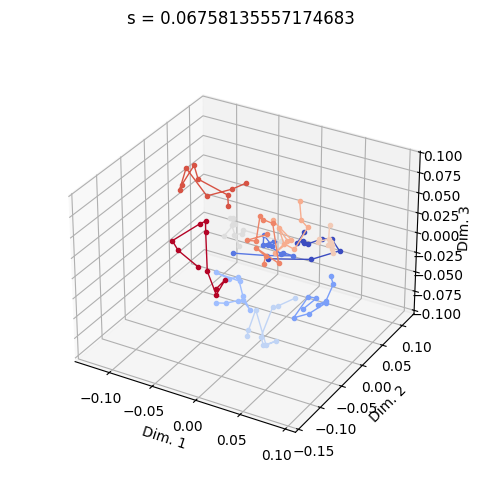

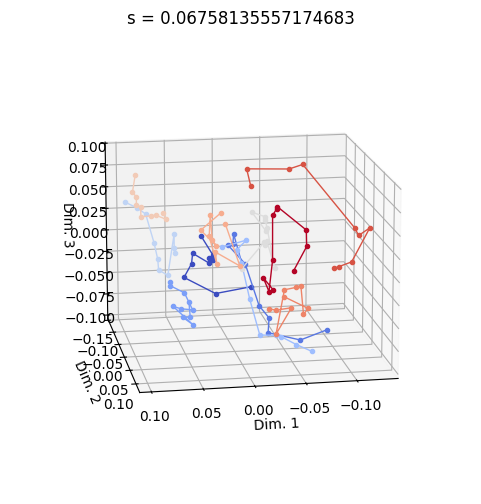

<Figure size 640x480 with 0 Axes>

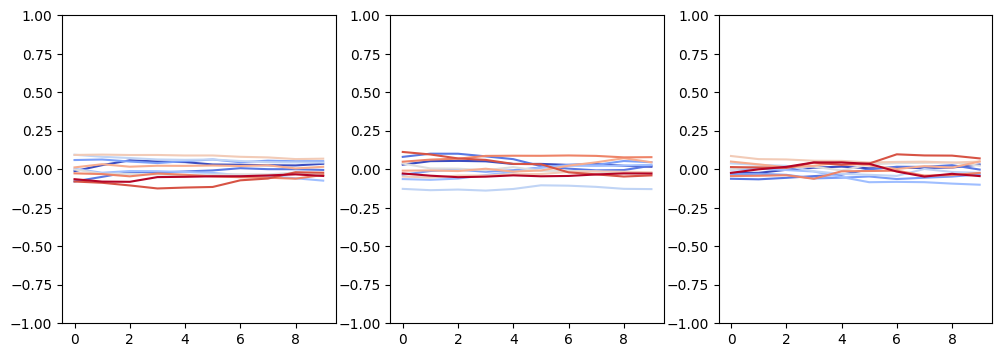

In [39]:
_, u, l2, scale = get_params(params, kernel_function=kernel_function)
K_u_u_K_u_A_alpha_H, K_A_u, K_u_u, _, _  = get_alpha(params, A, X_train, kernel_function, d)

X_reshaped = X_train.swapaxes(0,1).reshape(N,-1)
K_u_X = kernel_function(u, X_reshaped, l2=l2, scale=scale).reshape(-1,K_,T).swapaxes(0,1)  
Y = jnp.einsum('ji,kjm->kim',  K_u_u_K_u_A_alpha_H, K_u_X)
Y = center(Y)
Y = jnp.mean(Y.reshape(trials-split, -1, d, T), axis=0)

# for i in range(Y.shape[0]):
#     #Y = Y[:,:,:jnp.array(RTs).reshape(-1)[i]]
#     Y = Y[:,:,:int(jnp.mean(RTs, axis=0).squeeze()[i])]

plot_3D_K_coded(Y, elevation=10, azimuth=60)




analyse_projs(Y, RTs, ymin=-1, ymax=1)

# plot_3D(Y[:,:,:])
# plt.title(f'kSCA; s = {compute_S_all_pairs(Y)}')

In [26]:
fig = go.Figure()
num_time_points = Y.shape[-1]

color_scale = px.colors.diverging.RdBu 
for k in range(K_):
    x = Y[k, 0, :]
    y = Y[k, 1, :]
    z = Y[k, 2, :]

    color_index = int(k / K_ * (len(color_scale) - 1))  # Scale the index to the length of the color scale

    fig.add_trace(go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode='lines',
        line=dict(color=color_scale[color_index]),
        showlegend=False
    ))

fig.show()

Iteration 0, S: 0.024412499740719795, S_ratio: 7.390671089524403e-05
Iteration 10, S: -0.08771249651908875, S_ratio: -0.00032919729710556567
Iteration 20, S: 0.0037124999798834324, S_ratio: 9.17260695132427e-06
Iteration 30, S: 0.10278749465942383, S_ratio: 0.00027268589474260807
Iteration 40, S: 0.22732499241828918, S_ratio: 0.0007069478160701692
Iteration 50, S: 0.05288749933242798, S_ratio: 0.00015527800132986158
Iteration 60, S: -0.07494999468326569, S_ratio: -0.00012933477410115302
Iteration 70, S: 0.03720000013709068, S_ratio: 4.598793020704761e-05
Iteration 80, S: 0.588450014591217, S_ratio: 0.0004390097747091204
Iteration 90, S: 0.7286999821662903, S_ratio: 0.0003921666066162288
Iteration 100, S: 0.5303999781608582, S_ratio: 0.00011606607586145401
Iteration 110, S: 0.8631999492645264, S_ratio: 0.00021261535584926605
Iteration 120, S: 2.126199960708618, S_ratio: 0.0006196483736857772
Iteration 130, S: 1.187399983406067, S_ratio: 0.00039506953908130527
Iteration 140, S: 0.4143999

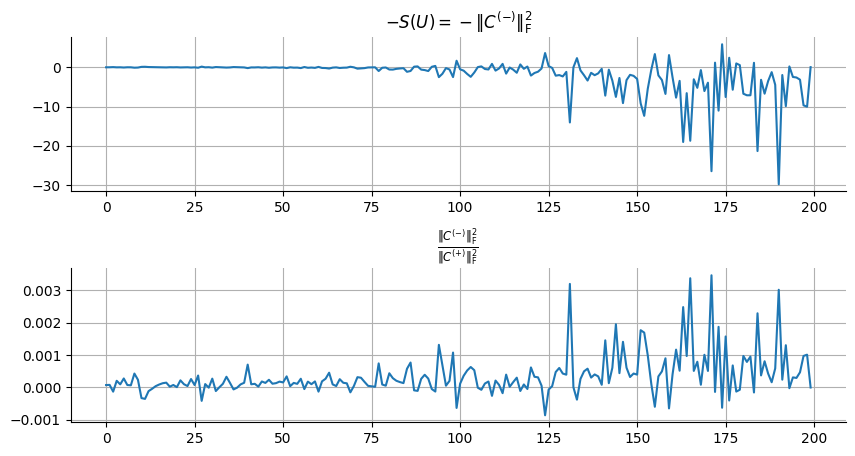

In [40]:
from linear_sca import *
wandb.init(project="", name="", mode="disabled")
U, ls_loss, ls_S_ratio = optimize(center(X_train), d=d, learning_rate=0.01, iterations=200) 
wandb.finish

get_loss_fig(ls_loss, ls_S_ratio )



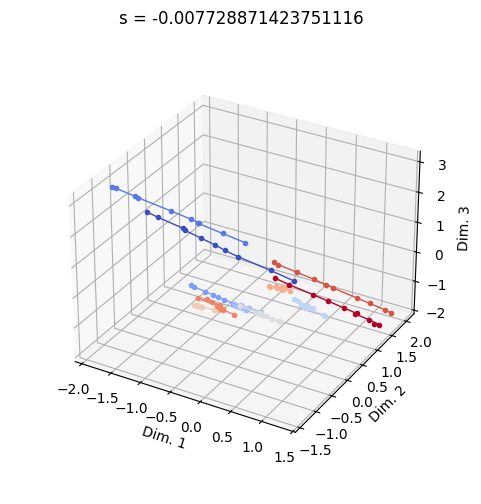

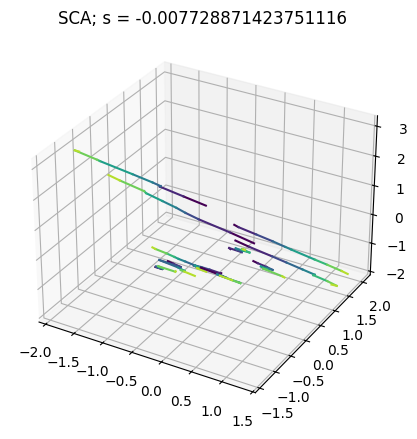

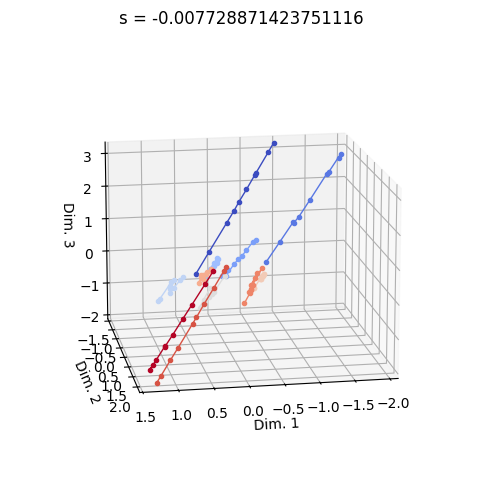

<Figure size 640x480 with 0 Axes>

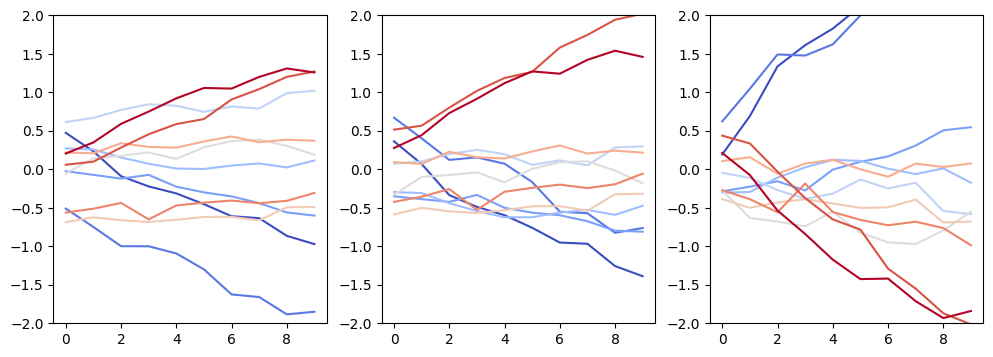

In [41]:
U_qr, _ = jnp.linalg.qr(U)        
Y = jnp.einsum('ji,kjl->kil', U_qr, center(X_train))
Y = jnp.mean(Y.reshape(trials-split, -1, d, T), axis=0)

# for i in range(Y.shape[0]):
#     #Y = Y[:,:,:jnp.array(RTs).reshape(-1)[i]]
#     Y = Y[:,:,:int(jnp.mean(RTs, axis=0).squeeze()[i])]
    
plot_3D_K_coded(Y)

plot_3D(Y[:,:,:])
plt.title(f'SCA; s = {compute_S_all_pairs(Y)}')

analyse_projs(Y, RTs, ymin=-2, ymax=2)

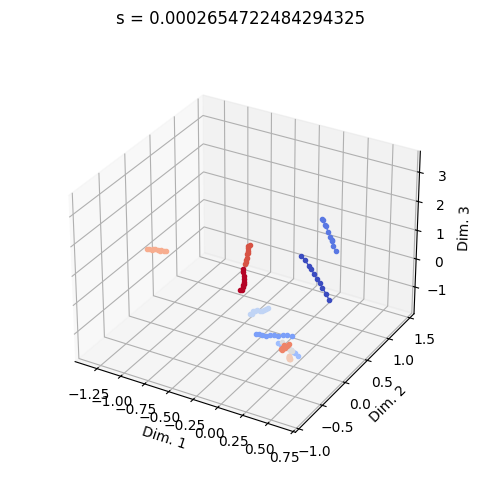

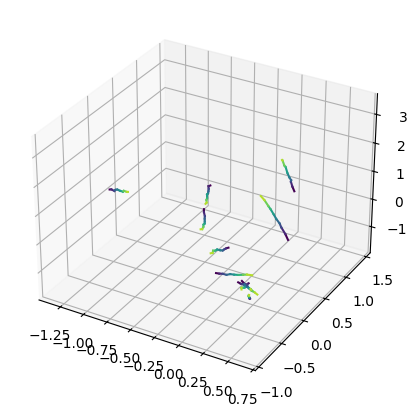

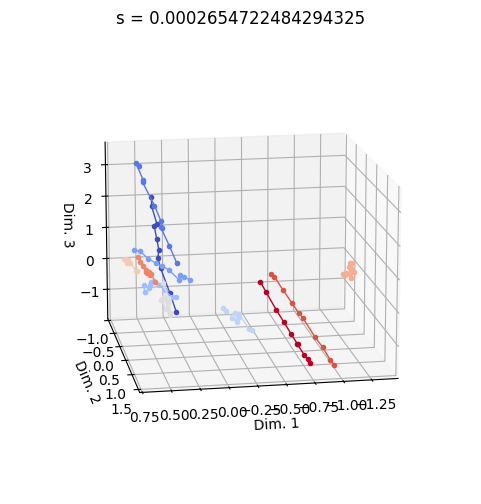

<Figure size 640x480 with 0 Axes>

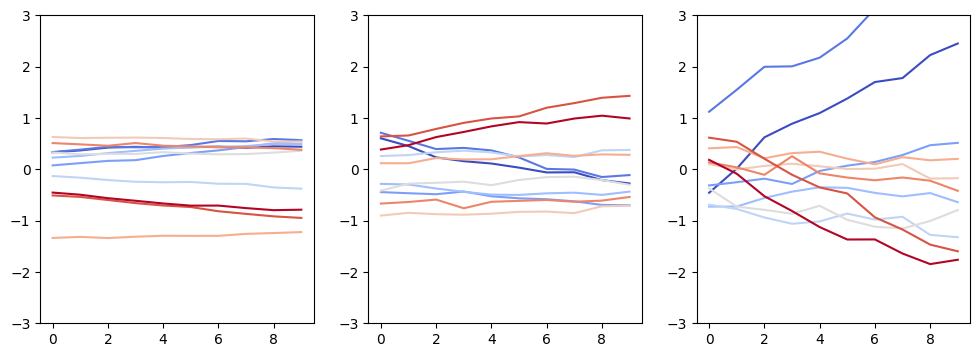

In [42]:
""" PCA """
Y_pca, PCs = get_pca(center(X_train), num_pcs=d)
Y_pca = jnp.mean(Y_pca.reshape(trials-split, -1, d, T), axis=0)
# for i in range(Y_pca.shape[0]):
#     Y_pca = Y_pca[:,:,:int(jnp.mean(RTs, axis=0).squeeze()[i])]
    
plot_3D_K_coded(jnp.array(Y_pca))

plot_3D(Y_pca)

analyse_projs(jnp.array(Y_pca), RTs, ymin=-3, ymax=3)

In [ ]:
fig = go.Figure()
num_time_points = Y.shape[-1]

color_scale = px.colors.diverging.RdBu 
for k in range(K):
    x = Y[k, 0, :]
    y = Y[k, 1, :]
    z = Y[k, 2, :]

    color_index = int(k / K * (len(color_scale) - 1))  # Scale the index to the length of the color scale

    fig.add_trace(go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode='lines',
        line=dict(color=color_scale[color_index]),
        showlegend=False
    ))

fig.show()

In [21]:
def analyse_projs(Y, RTs, ymin = -1, ymax=1):
    K, _, _ = Y.shape
    thresholds = jnp.floor(jnp.mean(RTs, axis=0)).astype(int)
    for i, idx in enumerate(thresholds):
        Y = Y.at[i, :, idx:].set(jnp.nan)


    plot_3D_K_coded(Y, rotate=True, azimuth=80, elevation=15)

    plt.figure()
    fig, axs = plt.subplots(1,3, figsize=(12,4))
    cmap = plt.get_cmap('coolwarm', K)
    for k in range(Y.shape[0]):
        color = cmap(k / (K - 1)) 
        axs[0].plot(Y[k, 0, :], color=color)
        axs[1].plot(Y[k, 1, :], color=color)
        axs[2].plot(Y[k, 2, :], color=color)

    for ax in axs:
        ax.set_ylim(ymin, ymax)

ANALYSE RESULTS

0.01852428
0.0046400675
0.0012885511


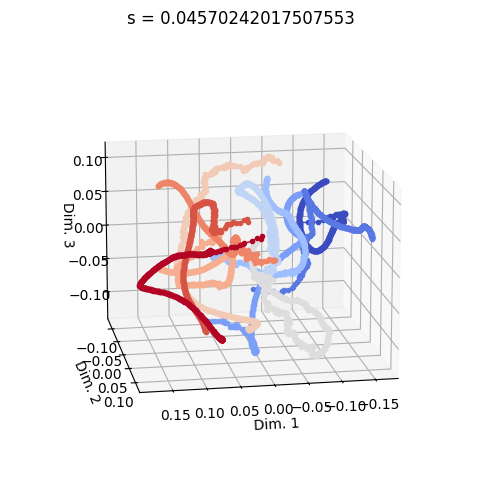

<Figure size 640x480 with 0 Axes>

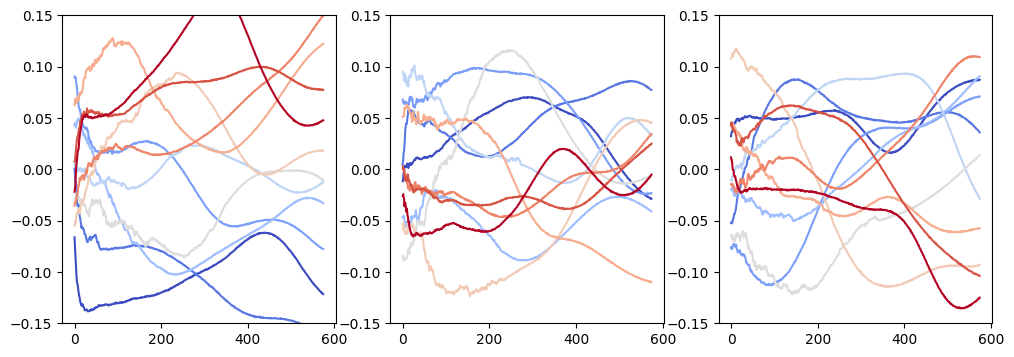

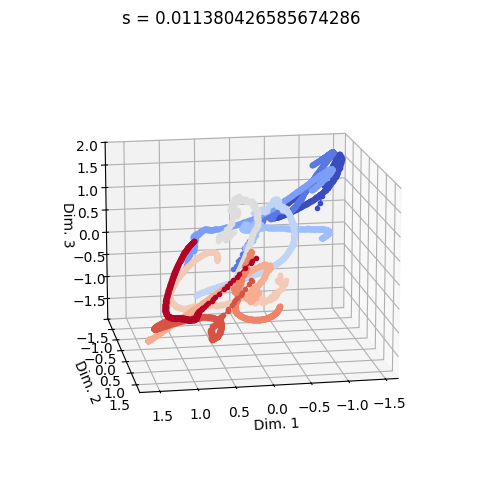

<Figure size 640x480 with 0 Axes>

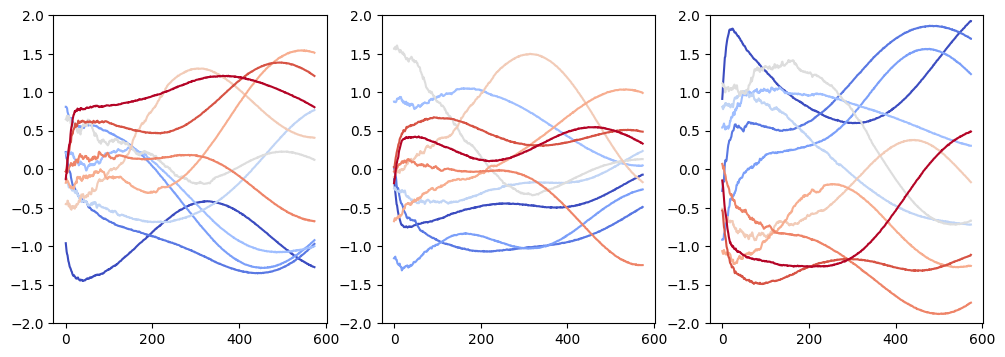

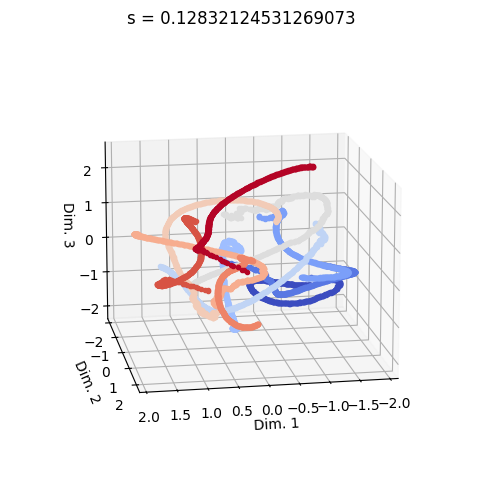

<Figure size 640x480 with 0 Axes>

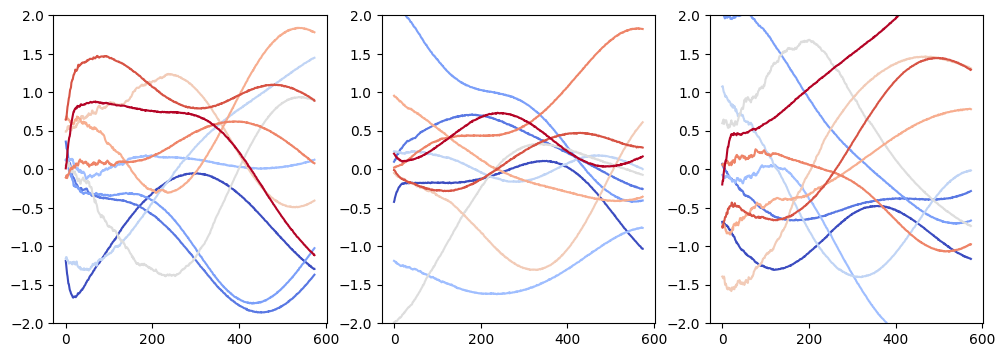

In [26]:
sigma = 4.0

Y_kSCA = jnp.load(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/DDM/single_trials/kSCA/Y_kSCA_3d_sigma{sigma}_proj_dims50_l20.1.npy')
Y_SCA = jnp.load(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/DDM/single_trials/SCA/Y_SCA_3d_sigma{sigma}_proj_dims50_l20.1.npy')
Y_PCA = jnp.load(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/DDM/single_trials/PCA/Y_PCA_3d_sigma{sigma}_proj_dims50_l20.1.npy')

print(compute_S_all_pairs(Y_kSCA))
print(compute_S_all_pairs(Y_SCA))
print(compute_S_all_pairs(Y_PCA))

Y_kSCA = jnp.load(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/DDM/single_trials/kSCA/Y_mean_test_kSCA_3d_sigma{sigma}_proj_dims50_l20.1.npy')
Y_SCA = jnp.load(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/DDM/single_trials/SCA/Y_mean_test_SCA_3d_sigma{sigma}_proj_dims50_l20.1.npy')
Y_PCA = jnp.load(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/DDM/single_trials/PCA/Y_mean_test_PCA_3d_sigma{sigma}_proj_dims50_l20.1.npy')
K = Y_kSCA.shape[0]
def analyse_projs(Y, RTs, ymin = -0.25, ymax=0.25):
    K, _, _ = Y.shape
    # thresholds = jnp.floor(jnp.mean(RTs, axis=0)).astype(int)
    # for i, idx in enumerate(thresholds):
    #     Y = Y.at[i, :, idx:].set(jnp.nan)


    plot_3D_K_coded(Y, rotate=True, azimuth=80, elevation=15)

    plt.figure()
    fig, axs = plt.subplots(1,3, figsize=(12,4))
    cmap = plt.get_cmap('coolwarm', K)
    for k in range(Y.shape[0]):
        color = cmap(k / (K - 1)) 
        axs[0].plot(Y[k, 0, :], color=color)
        axs[1].plot(Y[k, 1, :], color=color)
        axs[2].plot(Y[k, 2, :], color=color)

    for ax in axs:
        ax.set_ylim(ymin, ymax)

RTs=None
analyse_projs(Y_kSCA, RTs,  ymin = -0.15, ymax=0.15)
analyse_projs(Y_SCA, RTs, ymin = -2, ymax=2)
analyse_projs(Y_PCA, RTs, ymin = -2, ymax=2)


# plt.figure()
# fig, ax = plt.subplots(figsize=(4,4))
# cmap = plt.get_cmap('coolwarm', K)
# paths_avg = jnp.mean(paths, axis=0)
# thresholds = jnp.floor(jnp.mean(RTs, axis=0)).astype(int)
# for i, idx in enumerate(thresholds):
#     paths_avg = paths_avg.at[i, idx:].set(jnp.nan)

# for k in range(paths_avg.shape[0]):
#     color = cmap(k / (K - 1)) 
#     ax.plot(paths_avg[k,:], color=color)       



In [233]:


A = jnp.mean(paths, axis=0).reshape(-1)[:,None]
B = Y_SCA.swapaxes(1,2).reshape(-1, 3)
R2, _ = get_reg(B, A, B, A)

In [234]:
R2

0.9495487009232536